In [1]:
### Importing Libraries
import struct
import numpy as np
from array import array
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data=pd.read_csv('mnist_train.csv')

In [3]:
mydata=data[(data['label']==6) | (data['label']==9)]

pandas.core.frame.DataFrame

In [4]:
T_train=mydata['label']

In [5]:
X_train=mydata.drop(columns='label')

In [6]:
def vectortoimg(v,show=True):
    plt.imshow(v.reshape(28, 28),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

In [7]:
X_train=X_train.as_matrix()

C:\Users\Mr.Khiladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


numpy.ndarray

Checking multiple training vectors by plotting images.
Be patient:


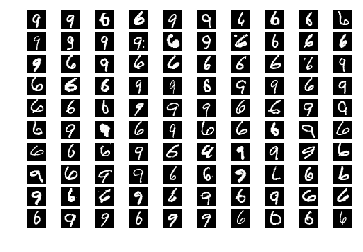

In [8]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(X_train[np.random.randint(len(T_train))],show=False)
plt.show()

In [9]:
meanvector=np.mean(X_train,axis=0)


In [10]:
np.savetxt("meanvector.csv", meanvector.astype(float), delimiter=",")

In [11]:
#len(data[data['label']==9]) ## Ans=5949
#len(data[data['label']==6]) ## Ans=5918

In [12]:
Z_train=X_train-meanvector

Checking multiple training vectors by plotting images.
Be patient:


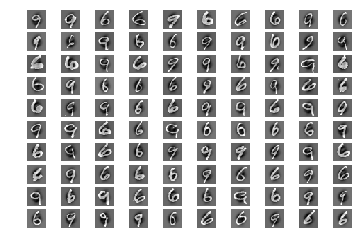

In [13]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(Z_train[np.random.randint(len(T_train))],show=False)
plt.show()

In [14]:
C_Train=np.cov(Z_train.T); print(np.shape(C_Train))

(784, 784)


In [15]:
Eigenvalues,Eigenvectors=np.linalg.eigh(C_Train)


In [16]:
np.argmax(Eigenvalues)  ## The Max (max important) Eigen Value is at the last 783 position. So last column / row is the eigen vector of max importance

783

In [17]:
## Next we have to determine whether columns or rows represent eigenvectors

In [18]:
row=Eigenvectors[-1,:];col=Eigenvectors[:,-1];

max(np.dot(C_Train,row)-(Eigenvalues[-1]*row))  ## Rows are not 

max(np.dot(C_Train,col)-(Eigenvalues[-1]*col))  #### matrix* EigenVector==EigenValue* EigenVector ,Therefore, Columns are EigenVectors

7.275957614183426e-11

In [19]:
Eigenvalues=np.flipud(Eigenvalues)
Eigenvectors=np.flipud(Eigenvectors.T)

In [20]:
row=Eigenvectors[0,:]

min(np.dot(C_Train,row)-(Eigenvalues[0]*row))  ## Rows are eigen vectors here 



-5.093170329928398e-11

In [21]:
Eigenvectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
np.allclose(np.dot(C_Train,row),Eigenvalues[0]*row)

True

In [23]:
np.savetxt("eigenvectors.csv", Eigenvectors[0:2,:].astype(float), delimiter=",")

In [24]:
prin_comp=np.dot(Z_train,Eigenvectors.T)

In [25]:
prin_comp.shape

(11867, 784)

In [29]:
np.savetxt("pc2.csv", prin_comp[:,0:2].astype(float), delimiter=",")
T_train=np.array(T_train)

In [30]:
x=np.append(prin_comp[:,0:2],T_train.reshape(-1,1),axis=1)

In [32]:
pcadata=pd.DataFrame(x,columns=['pc1','pc2','labels'])

In [33]:
#np.mean(pcadata[pcadata['labels']==6],axis=0)
#np.mean(pcadata[pcadata['labels']==9],axis=0)

In [34]:
#np.cov(pcadata[pcadata['labels']==6].iloc[:,0:2].T)
#np.cov(pcadata[pcadata['labels']==9].iloc[:,0:2].T)

In [35]:
#np.min(pcadata.iloc[:,0]) ## PC1 Min
#np.max(pcadata.iloc[:,0]) ## PC1 Max
#np.min(pcadata.iloc[:,1]) ## PC2 Min
#np.max(pcadata.iloc[:,1]) ## PC2 Max

In [91]:
def Hist2D(mydata,mybins):
    min1=min(mydata["pc1"])
    min2=min(mydata["pc2"])
    max1=max(mydata["pc1"])
    max2=max(mydata["pc2"])
    
    
    HN=np.zeros(shape=(mybins,mybins)).astype('int32')
    HP=np.zeros(shape=(mybins,mybins)).astype('int32')
    row=[round(((mybins-1)*((xi-min1)/(max1-min1)))) for xi in mydata["pc1"]]
    col=[round(((mybins-1)*((xj-min2)/(max2-min2)))) for xj in mydata["pc2"]]
    for i in range(len(mydata)):
        if mydata.iloc[i,2]==6:
            HN[row[i],col[i]]+=1
        else:
            HP[row[i],col[i]]+=1
    return HN,HP
        

In [100]:
HN,HP=Hist2D(pcadata,32)

In [102]:
np.savetxt("HN.csv", HN.astype(int), delimiter=",")
np.savetxt("HP.csv", HP.astype(int), delimiter=",")


In [259]:
test_data=pd.read_csv("mnist_test.csv")
test_data=test_data[(test_data['label']==6) | (test_data['label']==9)]

In [260]:
test_data1=np.array(test_data.drop(['label'],axis=1))

In [127]:
pos_test=test_data1[1])

In [132]:
np.savetxt("pos_test.csv", pos_test, delimiter=",")


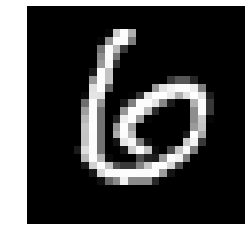

In [137]:
vectortoimg(test_data1[2])

In [138]:
neg_test=test_data1[2]

In [139]:
np.savetxt("neg_test.csv", neg_test, delimiter=",")


In [141]:
mean_neg=neg_test-meanvector

In [142]:
mean_pos=pos_test-meanvector

In [143]:
np.savetxt("mean_neg.csv", mean_neg, delimiter=",")
np.savetxt("mean_pos.csv", mean_pos, delimiter=",")


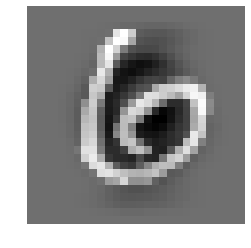

In [144]:
vectortoimg(mean_neg)

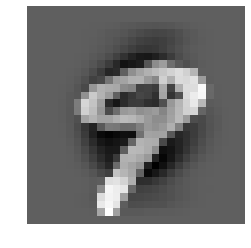

In [145]:
vectortoimg(mean_pos)

In [146]:
prin_comp_pos=np.dot(mean_pos,Eigenvectors.T)
prin_comp_neg=np.dot(mean_neg,Eigenvectors.T)

In [165]:
rp=np.dot(prin_comp_pos[0:2],Eigenvectors[0:2,:])
rn=np.dot(prin_comp_neg[0:2],Eigenvectors[0:2,:])

In [166]:
np.savetxt("rp.csv", rp, delimiter=",")

np.savetxt("rn.csv", rn, delimiter=",")


In [170]:
recn=rn+meanvector
np.savetxt("recn.csv", recn, delimiter=",")
recp=rp+meanvector
np.savetxt("recp.csv", recp, delimiter=",")


In [ ]:
def Hist2D(mydata,mybins):
    min1=min(mydata["pc1"])
    min2=min(mydata["pc2"])
    max1=max(mydata["pc1"])
    max2=max(mydata["pc2"])
    
    
    HN=np.zeros(shape=(mybins,mybins)).astype('int32')
    HP=np.zeros(shape=(mybins,mybins)).astype('int32')
    row=[round(((mybins-1)*((xi-min1)/(max1-min1)))) for xi in mydata["pc1"]]
    col=[round(((mybins-1)*((xj-min2)/(max2-min2)))) for xj in mydata["pc2"]]
    for i in range(len(mydata)):
        if mydata.iloc[i,2]==6:
            HN[row[i],col[i]]+=1
        else:
            HP[row[i],col[i]]+=1
    return HN,HP

In [198]:
def Queries(mydata,mybins,pc1_new,pc2_new):
    min1=min(mydata["pc1"])
    min2=min(mydata["pc2"])
    max1=max(mydata["pc1"])
    max2=max(mydata["pc2"])
    
    
    HN=np.zeros(shape=(mybins,mybins)).astype('int32')
    HP=np.zeros(shape=(mybins,mybins)).astype('int32')
    row=[round(((mybins-1)*((xi-min1)/(max1-min1)))) for xi in mydata["pc1"]]
    col=[round(((mybins-1)*((xj-min2)/(max2-min2)))) for xj in mydata["pc2"]]
    for i in range(len(mydata)):
        if mydata.iloc[i,2]==6:
            HN[row[i],col[i]]+=1
        else:
            HP[row[i],col[i]]+=1
    newrow=round(((mybins-1)*((pc1_new-min1)/(max1-min1)))).astype(int)
    newcol=round(((mybins-1)*((pc2_new-min2)/(max2-min2)))).astype(int)
    Probability=0
    Predicted=str()
    if HN[newrow,newcol] > HP[newrow,newcol]:
        Predicted="Negative:6"
        Probability=HN[newrow,newcol]/(HN[newrow,newcol]+HP[newrow,newcol])
    elif HN[newrow,newcol] < HP[newrow,newcol]:
        Predicted="Positive :9"
        Probability=HP[newrow,newcol]/(HN[newrow,newcol]+HP[newrow,newcol])
    else:
        Predicted="Indeterminate"
        Probability="Indeterminate"
    return HN,HP, Predicted, Probability,HN[newrow,newcol],HP[newrow,newcol]
        

In [203]:
Queries(pcadata,32,prin_comp_pos[0],prin_comp_pos[1])

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), 'Positive :9', 1.0, 0, 62)

In [204]:
Queries(pcadata,32,prin_comp_neg[0],prin_comp_neg[1])

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), 'Negative:6', 0.8571428571428571, 6, 1)

In [219]:
##Fdata-Negative
## Mdata=Positive
def BayesianClassifier(Fdata,Mdata,newheight,newhandspan):
    fcov=np.cov(Fdata,rowvar=False)
    mcov=np.cov(Mdata,rowvar=False)
    Fcount=int(Fdata.shape[0])
    Mcount=int(Mdata.shape[0])
    Fdet=(np.linalg.det(fcov))**0.5
    Mdet=(np.linalg.det(mcov))**0.5
    fmean=np.mean(Fdata)
    mmean=np.mean(Mdata)
    x_fmean=np.subtract([newheight,newhandspan],fmean)
    x_mmean=np.subtract([newheight,newhandspan],mmean)
    f=Fcount*(1/(2*np.pi*Fdet))*(np.e**(-0.5*(np.matmul(np.matmul(x_fmean,np.linalg.inv(fcov)),x_fmean.T))))
    m=Mcount*(1/(2*np.pi*Mdet))*(np.e**(-0.5*(np.matmul(np.matmul(x_mmean,np.linalg.inv(mcov)),x_mmean.T))))
    if f>m:
        return "Negative", (f/(f+m))
    elif f<m:
        return "positive",(m/(f+m))
    else:
        return "Indeterminate","Intedertminate"    

    
    
    
    
    
    
    
    
    

In [224]:
BayesianClassifier(pcadata[pcadata['labels']==6].drop(columns='labels'),pcadata[pcadata['labels']==9].drop(columns='labels'),prin_comp_neg[0],prin_comp_neg[1])

('Negative', 0.9547453500360116)

In [225]:
BayesianClassifier(pcadata[pcadata['labels']==6].drop(columns='labels'),pcadata[pcadata['labels']==9].drop(columns='labels'),prin_comp_pos[0],prin_comp_pos[1])

('positive', 0.9999566332384777)

In [267]:
def QueriesAcc(mydata,mybins,pc1_new,pc2_new):
    min1=min(mydata["pc1"])
    min2=min(mydata["pc2"])
    max1=max(mydata["pc1"])
    max2=max(mydata["pc2"])
    
    
    HN=np.zeros(shape=(mybins,mybins)).astype('int32')
    HP=np.zeros(shape=(mybins,mybins)).astype('int32')
    row=[round(((mybins-1)*((xi-min1)/(max1-min1)))) for xi in mydata["pc1"]]
    col=[round(((mybins-1)*((xj-min2)/(max2-min2)))) for xj in mydata["pc2"]]
    for i in range(len(mydata)):
        if mydata.iloc[i,2]==6:
            HN[row[i],col[i]]+=1
        else:
            HP[row[i],col[i]]+=1
    newrow=round(((mybins-1)*((pc1_new-min1)/(max1-min1)))).astype(int)
    newcol=round(((mybins-1)*((pc2_new-min2)/(max2-min2)))).astype(int)
    Probability=0
    Predicted=str()
    if HN[newrow,newcol] > HP[newrow,newcol]:
        Predicted=6
        Probability=HN[newrow,newcol]/(HN[newrow,newcol]+HP[newrow,newcol])
    elif HN[newrow,newcol] < HP[newrow,newcol]:
        Predicted=9
        Probability=HP[newrow,newcol]/(HN[newrow,newcol]+HP[newrow,newcol])
    else:
        Predicted=0
        Probability="Indeterminate"
    return Predicted
        

In [284]:
##Fdata-Negative
## Mdata=Positive
def BayesianClassifierAcc(Fdata,Mdata,newheight,newhandspan):
    fcov=np.cov(Fdata,rowvar=False)
    mcov=np.cov(Mdata,rowvar=False)
    Fcount=int(Fdata.shape[0])
    Mcount=int(Mdata.shape[0])
    Fdet=(np.linalg.det(fcov))**0.5
    Mdet=(np.linalg.det(mcov))**0.5
    fmean=np.mean(Fdata)
    mmean=np.mean(Mdata)
    x_fmean=np.subtract([newheight,newhandspan],fmean)
    x_mmean=np.subtract([newheight,newhandspan],mmean)
    f=Fcount*(1/(2*np.pi*Fdet))*(np.e**(-0.5*(np.matmul(np.matmul(x_fmean,np.linalg.inv(fcov)),x_fmean.T))))
    m=Mcount*(1/(2*np.pi*Mdet))*(np.e**(-0.5*(np.matmul(np.matmul(x_mmean,np.linalg.inv(mcov)),x_mmean.T))))
    if f>m:
        return 6
    elif f<m:
        return 9
    else:
        return 0   

    
    
    
    
    
    
    
    
    

In [261]:
Z_test=test_data1-meanvector

In [262]:
Z_test.shape

(1967, 784)

In [263]:
Z_test1=np.array(Z_test)

In [264]:
Z_test1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [265]:
pca_test=np.dot(Z_test1,Eigenvectors.T)

In [266]:
pca_test.shape

(1967, 784)

In [285]:
accr_his=[]
for u in range(len(pca_test):
    accr_his.append(QueriesAcc(pcadata,32,pca_test[u][0],pca_test[u][1]))
    
    
    
    

In [279]:
test_labels=np.array(test_data['label'])
test_labels

array([9, 9, 6, ..., 6, 9, 6], dtype=int64)

In [283]:
np.sum(accr_his==test_labels)/len(test_labels)

0.9761057447890188

In [286]:
accr_bay=[]
for u in range(len(pca_test)):
    accr_bay.append(BayesianClassifierAcc(pcadata[pcadata['labels']==6].drop(columns='labels'),pcadata[pcadata['labels']==9].drop(columns='labels'),pca_test[u][0],pca_test[u][1]))
    
    
    
    

In [282]:
test_labels.shape

(1967,)

In [ ]:
test_pca=np.dot(C_test,Eigenvalues.T)

In [232]:
test_pca.shape

(1967,)

In [290]:
np.sum(accr_bay==test_labels)/len(test_labels)

0.9796644636502287

In [291]:
np.sum(accr_bay==test_labels)

1927

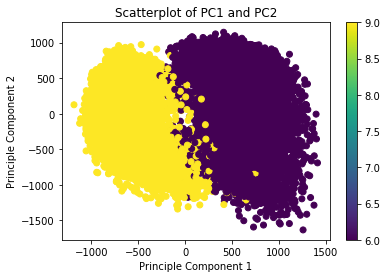

In [302]:
plt.scatter(pcadata['pc1'],pcadata['pc2'],c=pcadata['labels'])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Scatterplot of PC1 and PC2')
plt.colorbar()
plt.savefig('Scatterplot.jpeg',dpi=500)



In [154]:
R_neg=np.dot(prin_comp_neg[:2],Eigenvectors)

ValueError: shapes (2,) and (784,784) not aligned: 2 (dim 0) != 784 (dim 0)

In [159]:
Eigenvectors.shape

(784, 784)

In [156]:
R=np.dot(prin_comp,Eigenvectors)

In [158]:
R.shape

(11867, 784)

Checking multiple training vectors by plotting images.
Be patient:


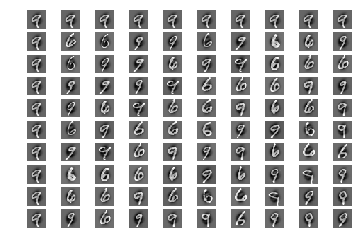

In [118]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(R[row*col],show=False)
plt.show()

In [119]:
Xrec=R+meanvector

Checking multiple training vectors by plotting images.
Be patient:


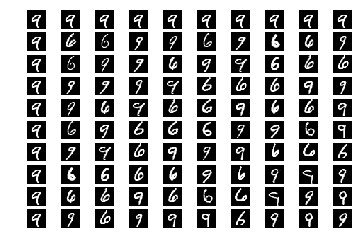

In [89]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(Xrec[row*col],show=False)
plt.show()

Checking multiple training vectors by plotting images.
Be patient:


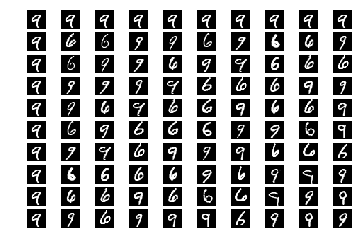

In [90]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(X_train[row*col],show=False)
plt.show()

In [91]:
Xrec2=(np.dot(prin_comp[:,0:2],Eigenvectors[0:2,:]))+meanvector

Checking multiple training vectors by plotting images.
Be patient:


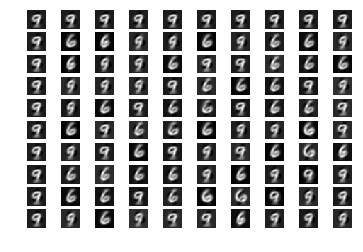

In [92]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(Xrec2[row*col],show=False)
plt.show()

In [95]:
Xrec2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [96]:
np.shape(Xrec2)

(11867, 784)

In [97]:
np.mean(prin_comp,axis=0)

array([-5.56171683e-14,  2.83426738e-14,  7.76339939e-14, -3.12598088e-14,
        2.46303918e-14, -2.98898571e-15,  1.61711791e-14,  1.20852739e-14,
        8.57656876e-15,  1.34983361e-14,  4.16236617e-14, -1.15104690e-14,
       -4.39725782e-14, -2.58853826e-14, -1.30911826e-14,  3.23782835e-14,
       -5.75427649e-14,  9.50265586e-15,  1.74944280e-14, -1.26157897e-14,
        2.05971771e-16,  1.26816341e-14, -1.11967213e-15, -1.79638520e-14,
        4.72298062e-15, -6.14415590e-14, -1.10170947e-14, -3.28896204e-14,
        9.18729901e-15, -4.02602962e-15, -3.33207241e-15, -2.47405628e-15,
        2.20916700e-14,  1.12098939e-14, -7.37456780e-15, -1.46216007e-14,
        5.14091171e-15, -1.04231296e-14,  2.68918900e-14,  7.93859515e-15,
        3.19615499e-15,  8.23887086e-16,  1.64573840e-14,  2.97701060e-15,
        2.37346541e-15, -2.09791829e-14,  5.52950380e-15,  2.56686333e-15,
        2.00837446e-14, -1.95792934e-15, -1.33079319e-14, -1.85494345e-14,
       -4.42240553e-15,  

In [98]:
np.dot(Eigenvectors[0,:],Eigenvectors[2,:])  ## Orthogonality check

1.0408340855860843e-16

In [99]:
prin_comp[0]

array([-8.81208514e+02, -4.44775744e+01,  2.52545037e+02,  1.25244873e+02,
       -2.04489471e+02,  8.74270328e+01,  1.67315144e+02, -2.44846226e+01,
        4.11881657e+02,  1.51617767e+02,  9.61862873e+01,  3.26266112e+02,
        2.12021243e+02, -6.52999521e+01, -7.77078279e+01, -2.42692533e+01,
        1.90456329e+02,  3.93462033e+01,  8.25336128e+01, -5.34647779e+01,
        4.72274749e+01,  4.74703717e+02,  3.26369616e+01,  8.93760359e+01,
       -9.06470681e+01,  2.59894677e+02, -2.36867608e+02,  2.39563700e+02,
        1.00840899e+02, -2.03861592e+01,  2.93369560e+01,  9.18841594e+01,
       -3.61447737e+01,  2.53723276e+02,  1.08407481e+02, -1.00061902e+00,
        1.23036357e+00,  1.90657765e+01,  4.68963191e+00,  2.69273576e+01,
       -1.71269104e+02,  3.72769500e+00,  3.98398378e+01,  8.39519203e+01,
        1.40454465e+02,  2.28866189e+00, -1.09428833e+01, -9.08566862e+01,
        1.02039745e+01, -1.55920945e+02,  2.31014302e+02, -1.61284645e+01,
        6.48809743e+01,  

In [103]:
prin_comp.shape

(11867, 784)

In [105]:
p2=prin_comp[:,0:2]